# 1. Estimate flow channel concentration    

This notebook uses analytical 1D reaction-diffusion model to simulate gradients in coupled family machine to calculate exogenous concentration to add in PA flow channel to complement (i.e. restore) PA-WT like-gradients in PA double mutant conditions. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
from pathlib import Path

def coth(z):
    """
    Numerically stable coth(z) = cosh(z)/sinh(z); handle small z with series
    
    Parameters:
    -----------
    z : array_like
        Input values
        
    Returns:
    --------
    array_like
        Hyperbolic cotangent values
    """
    z = np.asarray(z, dtype=float)
    out = np.empty_like(z)
    small = np.abs(z) < 1e-6
    if np.any(~small):
        out[~small] = np.cosh(z[~small]) / np.sinh(z[~small])
    if np.any(small):
        # series: coth z ~ 1/z + z/3 for small z
        out[small] = 1.0 / z[small] + z[small] / 3.0
    return out if out.shape else out.item()

def c_in_from_params(params):
    """
    Calculate c_in from parameter dictionary using no-producer formula:
    c_in = c_max * [1 + k * coth(kL) * (L + d/alpha)]
    
    Parameters:
    -----------
    params : dict
        Dictionary with keys: 'c_max', 'A', 'L', 'd', 'W', 'W_gap'
        
    Returns:
    --------
    float
        Inlet concentration c_in
    """
    c_max = params['c_max']
    A = params['A']
    L = params['L']
    d = params['d']
    W = params['W']
    W_gap = params['W_gap']
    
    alpha = W_gap / W
    k = np.sqrt(A)
    return c_max * (1.0 + k * coth(k * L) * (L + d / alpha))

def calculate_c_in_from_dataframe(df, c_max_col='c_max', A_col='A', 
                                 L=50.0, d=3.0, W=50.0, W_gap=12.5,
                                 percentiles=[5, 25, 50, 75, 95]):
    """
    Calculate c_in for each row in dataframe and return percentile statistics.
    
    This function preserves correlations between parameters by using paired
    observations from the dataframe rather than sampling from independent distributions.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with columns for c_max and A parameters (one row per observation)
    c_max_col : str, optional
        Column name for c_max parameter (default: 'c_max')
    A_col : str, optional
        Column name for A parameter (default: 'A')
    L : float, optional
        Chamber length in µm (default: 50.0)
    d : float, optional
        Gap length in µm (default: 3.0)
    W : float, optional
        Chamber width in µm (default: 50.0)
    W_gap : float, optional
        Gap width in µm (default: 12.5)
    percentiles : list, optional
        Percentiles to calculate for output (default: [5, 25, 50, 75, 95])
        
    Returns:
    --------
    dict
        Dictionary with 'values' (all c_in values) and 'percentiles' keys

    """
    # Validate inputs
    if c_max_col not in df.columns:
        raise ValueError(f"Column '{c_max_col}' not found in dataframe")
    if A_col not in df.columns:
        raise ValueError(f"Column '{A_col}' not found in dataframe")
    
    # Calculate c_in for each row
    c_in_values = []
    
    for _, row in df.iterrows():
        params = {
            'c_max': row[c_max_col],
            'A': row[A_col],
            'L': L,
            'd': d,
            'W': W,
            'W_gap': W_gap
        }
        c_in_values.append(c_in_from_params(params))
    
    c_in_values = np.array(c_in_values)
    
    # Calculate percentiles
    percentile_results = {}
    for p in percentiles:
        percentile_results[p] = np.percentile(c_in_values, p)
    
    return {
        'values': c_in_values,
        'percentiles': percentile_results,
        'n_observations': len(c_in_values)
    }

def build_profile_from_params(params, nx=1200):
    """
    Build concentration profile c(x) from parameter dictionary.
    
    Parameters:
    -----------
    params : dict
        Dictionary with keys: 'c_max', 'A', 'L', 'd', 'W', 'W_gap'
    nx : int, optional
        Number of spatial points
        
    Returns:
    --------
    tuple
        (x, c, c_in) where x is position array, c is concentration array, 
        c_in is inlet concentration
    """
    c_max = params['c_max']
    A = params['A']
    L = params['L']
    d = params['d']
    W = params['W']
    W_gap = params['W_gap']
    
    alpha = W_gap / W
    k = np.sqrt(A)
    M = c_max / np.sinh(k * L)
    a2 = -(W / W_gap) * k * c_max * coth(k * L)
    a1 = -k * c_max * coth(k * L)
    b2 = c_max - a2 * (L + d)
    c_in = c_in_from_params(params)

    x = np.linspace(0.0, 2.0 * L + d, nx)
    c = np.zeros_like(x)

    m1 = x < L
    m2 = (x >= L) & (x < L + d)
    m3 = x >= L + d

    c[m1] = a1 * x[m1] + c_in
    c[m2] = a2 * x[m2] + b2
    c[m3] = M * np.sinh(k * (2.0 * L + d - x[m3]))

    return x, c, c_in

def plot_profile(ax, params, **plot_kwargs):
    """
    Plot concentration profile on specified axes object.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axes object to plot on
    params : dict
        Parameter dictionary with keys: 'c_max', 'A', 'L', 'd', 'W', 'W_gap'
    **plot_kwargs : dict
        Additional keyword arguments for plt.plot() (e.g., color, label, linestyle, linewidth)
        
    Returns:
    --------
    tuple
        (line, x, c, c_in) where line is the plotted line object, x is position array,
        c is concentration array, c_in is inlet concentration
    """
    x, c, c_in = build_profile_from_params(params)
    line = ax.plot(x, c, **plot_kwargs)[0]

    ax.plot(x, c, linewidth=2, label="c(x)")
    ax.axvline(params['L'], color="k", linestyle="--", linewidth=1, label="x = L")
    ax.axvline(params['L'] + params['d'], color="r", linestyle="--", linewidth=1, label="x = L + d")

    # markers for c_in and c_0
    ax.plot([params['L'] + params['d']], params['c_max'], "o", label="c_0 at x=L+d")







    return None

def print_results(c_in_result, label, unit='µM'):
    """
    Print summary statistics of c_in results.
    
    Parameters:
    -----------
    c_in_result : dict
        Result dictionary from calculate_c_in_from_dataframe
    label : str
        Label for the dataset (e.g., 'HQNO', 'RHL')
    unit : str, optional
        Unit of concentration (default: 'µM')
    """

    percentiles = list(c_in_result['percentiles'].keys())
    values = list(c_in_result['percentiles'].values())

    print(f"Results for c_in {label}:")
    if len(percentiles) == 5:
        print(f" Median: {values[2]:.2f} {unit}")
        print(f" ({percentiles[1]}-{percentiles[3]}%): {values[1]:.2f} - {values[3]:.2f} {unit}; ({percentiles[0]}-{percentiles[4]}%): {values[0]:.2f} - {values[4]:.2f} {unit}")
    else:
        for p, value in c_in_result['percentiles'].items():
            print(f"  {p}th percentile: {value:.4f}")
    return


Results for c_in HQNO Legacy:
 Median: 478.58 nM
 (25-75%): 367.87 - 617.40 nM; (5-95%): 266.34 - 850.48 nM
Results for c_in HQNO spline:
 Median: 190.61 nM
 (25-75%): 115.25 - 250.42 nM; (5-95%): 93.62 - 623.89 nM
Results for c_in HQNO hill:
 Median: 394.32 nM
 (25-75%): 308.77 - 553.03 nM; (5-95%): 207.88 - 697.81 nM
Results for c_in RHL Legacy:
 Median: 160.47 µM
 (25-75%): 112.87 - 197.49 µM; (5-95%): 70.90 - 217.83 µM
Results for c_in RHL spline:
 Median: 200.47 µM
 (25-75%): 172.78 - 224.55 µM; (5-95%): 97.32 - 280.63 µM
Results for c_in RHL hill:
 Median: 106.01 µM
 (25-75%): 84.35 - 130.56 µM; (5-95%): 80.27 - 185.23 µM


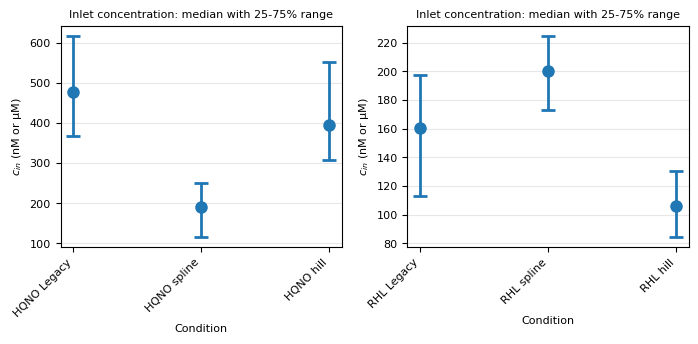

In [ ]:
df_h_legacy = pd.read_csv(Path.cwd().parent / '2_gradient_inference_legacy' / 'data' / '2_hqno_diffusion_model_fits_legacy.csv')
df_h_spline = pd.read_csv(Path.cwd().parent / '2_gradient_inference_altbg' / 'data' / '2_hqno_diffusion_model_fits_hybrid.csv')
df_h_hill = pd.read_csv(Path.cwd().parent / '2_gradient_inference_altbg' / 'data' / '2_hqno_diffusion_model_fits_hill.csv')

df_r_legacy = pd.read_csv(Path.cwd().parent / '2_gradient_inference_legacy' / 'data' / '2_rhl_diffusion_model_fits_legacy.csv')
df_r_spline = pd.read_csv(Path.cwd().parent / '2_gradient_inference_altbg' / 'data' / '2_rhl_diffusion_model_fits_hybrid.csv')
df_r_hill = pd.read_csv(Path.cwd().parent / '2_gradient_inference_altbg' / 'data' / '2_rhl_diffusion_model_fits_hill.csv')
# Example usage with original parameters
default_params = {
    'L': 50.0,          # µm, chamber length
    'd': 3.0,           # µm, gap length
    'W': 50.0,          # µm, chamber width
    'W_gap': 12.5       # µm, gap width (0.25 * W)
}


c_in_h_spline = calculate_c_in_from_dataframe(
    df_h_spline, **default_params,
    percentiles=[5, 25, 50, 75, 95])

c_in_h_legacy = calculate_c_in_from_dataframe(
    df_h_legacy, **default_params,
    percentiles=[5, 25, 50, 75, 95])

c_in_h_hill = calculate_c_in_from_dataframe(
    df_h_hill, **default_params,
    percentiles=[5, 25, 50, 75, 95])

c_in_r_spline = calculate_c_in_from_dataframe(
    df_r_spline, **default_params,
    percentiles=[5, 25, 50, 75, 95])

c_in_r_legacy = calculate_c_in_from_dataframe(
    df_r_legacy, **default_params,
    percentiles=[5, 25, 50, 75, 95])

c_in_r_hill = calculate_c_in_from_dataframe(
    df_r_hill, **default_params,
    percentiles=[5, 25, 50, 75, 95])    

print_results(c_in_h_legacy, label='HQNO Legacy', unit='nM')
print_results(c_in_h_spline, label='HQNO spline', unit='nM')
print_results(c_in_h_hill, label='HQNO hill', unit='nM')
print_results(c_in_r_legacy, label='RHL Legacy', unit='µM')
print_results(c_in_r_spline, label='RHL spline', unit='µM')
print_results(c_in_r_hill, label='RHL hill', unit='µM')


# Create bar plot with error bars for c_in values
fig, ax = plt.subplots(1,2, figsize=(18/2.54, 9/2.54))

to_plot0 = {    
    'HQNO Legacy': c_in_h_legacy['percentiles'],
    'HQNO spline': c_in_h_spline['percentiles'],
    'HQNO hill': c_in_h_hill['percentiles'],
}

to_plot1 = {    
    'RHL Legacy': c_in_r_legacy['percentiles'],
    'RHL spline': c_in_r_spline['percentiles'],
    'RHL hill': c_in_r_hill['percentiles'],
}

to_plot_list = [to_plot0, to_plot1]

for to_plot, axi in zip(to_plot_list, ax):

    conditions = list(to_plot.keys())
    medians = [to_plot[cond][50] for cond in conditions]
    lower_25 = [to_plot[cond][25] for cond in conditions]
    upper_75 = [to_plot[cond][75] for cond in conditions]

    # Calculate error bars (distance from median)
    yerr_lower = [medians[i] - lower_25[i] for i in range(len(conditions))]
    yerr_upper = [upper_75[i] - medians[i] for i in range(len(conditions))]

    x_pos = np.arange(len(conditions))
    axi.errorbar(x_pos, medians, yerr=[yerr_lower, yerr_upper], 
                fmt='o', capsize=5, capthick=2, markersize=8, linewidth=2)
    axi.set_xticks(x_pos)
    axi.set_xticklabels(conditions, rotation=45, ha='right')
    axi.set_ylabel('$c_{in}$ (nM or µM)', fontsize=8)
    axi.set_xlabel('Condition', fontsize=8)
    axi.set_title('Inlet concentration: median with 25-75% range', fontsize=8)
    axi.grid(True, alpha=0.3, axis='y')
    for axi in ax:
        axi.tick_params(axis='both', labelsize=8)




plt.tight_layout()

#
to_plot = {'HQNO': df_h, 'RHL': df_r, 'HQNO Legacy': df_h_legacy, 'RHL Legacy': df_r_legacy, 'HQNO Alt BG': df_h_alt, 'RHL Alt BG': df_r_alt}
           
fig, ax = plt.subplots(2,2, figsize=(16/2.54, 12/2.54))
for axi, (label, df_plot) in zip(ax.flatten(), to_plot.items()):
    median_params = {
        'c_max': df_plot['c_max'].median(),
        'A': df_plot['A'].median(),
        'L': default_params['L'],
        'd': default_params['d'],
        'W': default_params['W'],
        'W_gap': default_params['W_gap']
    }
    plot_profile(axi, median_params, color='blue', linewidth=2)
    axi.set_title(label)
    axi.set_xlabel('Position x (µm)')
    axi.set_ylabel('Concentration c (µM or nM)')
    axi.grid(True)

plt.tight_layout()

